# **📦 0. Setup and Configuration**

To prepare the runtime environment for AI-assisted patient simulation and analysis by:

*   Installing required dependencies
*   Initializing credentials for Azure OpenAI and Hugging Face
*   Validating API keys via secure secrets.json loading

**Step 1: Install Core Dependencies**

Install the essential Python libraries needed for GenAI data generation and EDA.

In [4]:
# Install Core Dependencies
!pip install -q openai numpy pandas
!pip install -q ydata-profiling
!pip install -q transformers
!pip install tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 118.2 MB/s eta 0:00:00


**Step 2: Set Working Directory**

All generated data files (e.g., raw outputs, datasets, summaries) will be saved to this path for clarity and version control.

In [5]:
# Set Working Directory
my_file_path = "/content/drive/MyDrive/UM Data Science Course Information/WQD7005/Assignment Project/"

**Step 3: Setup Hugging Face Token**

plan to access transformer models (e.g., MiniLM, BERT-tiny), login to Hugging Face Hub is required.

In [6]:
# Setup Hugging Face Token
from huggingface_hub import notebook_login
notebook_login()

**Step 4: Securely Load Azure API Credentials**

Using secrets.json avoids hardcoding sensitive information. This supports secure API usage and easier sharing of my notebook.

In [7]:
# Securely Load Azure API Credentials
# Azure endpoint and keys
import json

# Load secrets.json after upload
with open(my_file_path+"secrets.json", "r") as f:
    secrets = json.load(f)

endpoint = secrets["AZURE_ENDPOINT"]
subscription_key = secrets["AZURE_KEY"]

**Step 5: Configure Azure OpenAI Client and Define GPT Prompt Wrapper**

*   **api_version**: ensures compatibility with latest GPT-4o deployment and
*   **deployment**: name matches my Azure OpenAI Studio setting.
*   **model_prompt**: This utility function encapsulates the entire GPT-4o interaction, allowing clean and reusable prompting for various sections (data simulation, summarization, classification, etc.)




In [8]:
# Import Supporting Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from openai import AzureOpenAI
import random
import time

# Configure Azure OpenAI Client
api_version = "2024-12-01-preview"
deployment = "gpt-4o"
client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=subscription_key,
)
# Prompt execution wrapper for reuse
def model_prompt(prompt, system_prompt="Act as a professional clinicians.", temperature=0.7, max_tokens=4096):
    response = client.chat.completions.create(
        model=deployment,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        max_tokens=max_tokens,
        temperature=temperature,
    )
    return response.choices[0].message.content

**Step 6: Single Sample Data Generation via GPT (Validation Prompt)**

To verify the response structure of GPT-4o by generating a realistic single-patient daily monitoring record, ensuring the output conforms to expected JSON schema for later batch generation.

In [9]:
# Single Sample Data Generation via model
data_prompt = """
Generate a single, realistic patient monitoring record for one randomly selected adult patient.

Provide the following fields:
- oxygen_saturation (in %)
- heart_rate (in bpm)
- temperature (in °C)
- blood_pressure (systolic/diastolic, e.g. "120/80")
- weight (in kg)
- blood_glucose (in mg/dL)

At the end, include a brief clinical_note (1–2 sentences, max 30 words) summarizing the patient status based on the values above. Use professional clinical tone with realistic variation (e.g. stable, recovering, mild concerns).

Output as a valid JSON object with keys:
oxygen_saturation, heart_rate, temperature, blood_pressure, weight, blood_glucose, clinical_note.

Constraints:
- Only output one JSON object.
- No markdown or explanation.
- Include realistic variation across different health conditions (e.g. fatigue, post-op, dietary changes, stress).
- Ensure all fields are complete, no missing values.
"""

print(model_prompt(data_prompt))

{
  "oxygen_saturation": 95,
  "heart_rate": 88,
  "temperature": 37.5,
  "blood_pressure": "130/85",
  "weight": 72,
  "blood_glucose": 145,
  "clinical_note": "Patient exhibits mild hyperglycemia and elevated blood pressure; overall vitals suggest moderate stress or dietary changes. Monitoring recommended for further stabilization."
}


# **🧩 1. Dataset Simulation using GenAI**

This section outlines the complete process of generating synthetic inpatient monitoring data using a GenAI-powered approach.
It simulates a realistic clinical setting where multiple patients are monitored daily for up to 30 days.
Vital signs and clinical notes are generated based on assigned medical scenarios, ensuring medically coherent trends suitable for downstream exploratory analysis and machine learning modeling.

**Step 1: Prompt Engineering with Clinical Context**

The prompt defines the required fields (vital signs + clinical note), instructs model on how to simulate recovery trends, controls for missing value logic, and constrains the output to valid JSON without extra formatting.

**Step 2: Generate and Save Raw Outputs**

To generate 30-day clinical data per patient using model and safely store each raw response as .txt for later parsing.

**Step 3: Parse and Build the Final Dataset**

To transform model-generated .txt files into a clean and structured DataFrame, validating JSON format and extracting fields.

**Step 4: Final Export to CSV**

To save the simulated and parsed data in a structured format suitable for downstream analytics and visualization.

**Step 1: Configuration and Library Setup**

Import essential libraries (e.g., pandas, numpy, json, re, glob) and define basic configuration. This ensures the simulation pipeline runs in a clean and reproducible environment.

In [7]:
import pandas as pd
import numpy as np
import json
import time
import re
import os
import glob

# Configuration
num_patients = 500
start_date_str = "2025-01-01"
raw_output_dir = os.path.join(my_file_path, "data")
os.makedirs(raw_output_dir, exist_ok=True)

**Step 2: Prompt Engineering with Clinical Context**

Design a dynamic prompt that tells model GPT-4o:
1. To act as a clinical simulation engine

2. To choose one of 4 scenarios (e.g., post-surgery, infection, chronic illness, or acute deterioration)

3. To generate daily vitals and notes for each patient with 10–30 days of monitoring

4. To follow professional tone and simulate realistic recovery or decline

5. To occasionally omit 1 field (e.g., temperature, weight, blood_glucose) on 1–3 days

This prompt ensures data is diverse, realistic, and medically grounded.

In [8]:
# === Prompt Generator 1 ===
def generate_patient_prompt(patient_id, start_date):
    return f"""
You are a clinical simulation engine.

Generate a valid JSON array of **daily hospital monitoring records** for patient {patient_id}, starting from {start_date} (YYYY-MM-DD).

---

SCENARIO & DURATION INSTRUCTIONS:
- Randomly choose ONE of the following clinical scenarios for the patient:
  1. **Post-surgery recovery** → 18–30 days
  2. **Moderate infection (e.g. pneumonia)** → 15–25 days
  3. **Chronic illness flare-up (e.g. diabetes complications, hypertension crisis)** → 20–30 days
  4. **Acute deterioration (e.g. sepsis, cardiac failure)** → 10–15 days (with possible death or ICU transfer)

- Based on the chosen scenario, simulate a realistic number of monitoring days accordingly.
- Most patients should remain under monitoring for **more than 20 days**.
- Only a small number of cases should stop early due to rapid recovery or deterioration.
- If the patient recovers or deteriorates, you may stop early (but never before day 10).

---

EACH RECORD MUST INCLUDE:
- date
- oxygen_saturation (in %)
- heart_rate (in bpm)
- temperature (in °C)
- blood_pressure (format: "systolic/diastolic")
- weight (in kg)
- blood_glucose (in mg/dL)
- clinical_note: a brief clinical_note (2–3 sentences, max 35 words) summarizing the patient status based on the values above. Use professional clinical tone with realistic variation

---

MISSING DATA RULES:
- On no more than 3 random days, omit 1 of: temperature, weight, blood_glucose.
- Do not use nulls or placeholders. Simply omit the key entirely.

---

OUTPUT RULES:
- Return only a **valid JSON array** of N records (N = 10 to 30 depending on scenario).
- No markdown, No explanation, No code block.
- Just pure JSON.
"""

In [9]:
# === Prompt Generator 2 ===
# Monitor each patient's 30-day record of prompts
def generate_patient_prompt_30days(patient_id, start_date):
    return f"""
Generate a JSON array of 30 daily monitoring records for patient {patient_id}, starting from {start_date} (YYYY-MM-DD).

Each record must include:
- date
- oxygen_saturation (%)
- heart_rate (bpm)
- temperature (°C)
- blood_pressure ("systolic/diastolic")
- weight (kg)
- blood_glucose (mg/dL)
- clinical_note (2–3 sentences in professional tone, max 35 words)

Instructions:
- Choose a realistic medical scenario (e.g. infection, post-surgery, pregnancy, anxiety, fatigue)
- Simulate realistic changes over 30 days: early-stage symptoms → improvement → stabilization or recovery
- Use only professional clinical language, describing daily changes, recovery, and trends
- Avoid device/system mentions

Missing Data Instructions:
- Omit at most 1 field per day, no more than 3 total days
- Only temperature, weight, and blood_glucose may be missing
- Do not use null/empty values—omit keys entirely

Output only a valid JSON array of 30 objects. No markdown, no code block, no explanation.
"""

**Step 3: Generate and Save Raw Output**

Loop over all patient IDs and:

1. Send the prompt to GPT-4o
2. Receive the response (a JSON array)
3. Save the raw output to a .txt file for traceability and debugging

Each patient gets one raw output file (data_output_Pxxxx.txt) stored safely.

In [9]:
# === Phase 1: Generation and Save Raw Output ===
for pid in range(1, num_patients + 1):
    patient_id = f"P{pid:04d}"
    prompt = generate_patient_prompt(patient_id, start_date_str)
    raw_output = model_prompt(prompt)

    with open(f"{raw_output_dir}/data_output_{patient_id}.txt", "w") as f:
        f.write(raw_output)

    print(f"Saved output for patient id: {patient_id}.")
    time.sleep(0.25)

Saved output for patient id: P0001.
Saved output for patient id: P0002.
Saved output for patient id: P0003.
Saved output for patient id: P0004.
Saved output for patient id: P0005.
Saved output for patient id: P0006.
Saved output for patient id: P0007.
Saved output for patient id: P0008.
Saved output for patient id: P0009.
Saved output for patient id: P0010.
Saved output for patient id: P0011.
Saved output for patient id: P0012.
Saved output for patient id: P0013.
Saved output for patient id: P0014.
Saved output for patient id: P0015.
Saved output for patient id: P0016.
Saved output for patient id: P0017.
Saved output for patient id: P0018.
Saved output for patient id: P0019.
Saved output for patient id: P0020.
Saved output for patient id: P0021.
Saved output for patient id: P0022.
Saved output for patient id: P0023.
Saved output for patient id: P0024.
Saved output for patient id: P0025.
Saved output for patient id: P0026.
Saved output for patient id: P0027.
Saved output for patient id:

**Special Handling: Regenerating Patient P0264 Monitoring Records**

During the JSON-to-DataFrame parsing phase, it was discovered that some patients' monitoring data had formatting issues that prevented successful conversion. This ensures the dataset remains complete and all patients are properly processed for subsequent analysis.

In [14]:
# Define Patient ID
pid = 264
patient_id = f"P{pid:04d}"

# Generate Prompt
prompt = generate_patient_prompt(patient_id, start_date_str)

# Call GenAI model
raw_output = model_prompt(prompt)

# Save output
with open(f"{raw_output_dir}/data_output_{patient_id}.txt", "w") as f:
    f.write(raw_output)

print(f"Saved new output for patient id: {patient_id}.")


Saved new output for patient id: P0264.


**Step 4: Parse and Build the Final Dataset**

Loop over all patient IDs and:

1. Validate and parse each .txt file using json.loads
2. Extract daily records into a pandas.DataFrame

This ensures that malformed or empty outputs are skipped, and clean, structured data is retained.

In [15]:
# === Utility Functions ===
def parse_json_from_prompt(raw_output):
    clean_text = re.sub(r"```json|```", "", raw_output).strip()
    return json.loads(clean_text)

def is_valid_json(text):
    try:
        json.loads(text)
        return True
    except json.JSONDecodeError as e:
        print("JSON error:", e)
        return False
# === Phase 2: Parse Raw Output into DataFrame ===
records = []

for file_path in sorted(glob.glob(f"{raw_output_dir}/data_output_P*.txt")):
    patient_id = os.path.basename(file_path).split("_")[-1].split(".")[0]

    try:
        with open(file_path, "r") as f:
            raw_output = f.read()

        # Parse JSON
        daily_data = json.loads(raw_output)
        monitoring_days = len(daily_data)

        for i, day in enumerate(daily_data):
            records.append({
                "patient_id": patient_id,
                "timestamp": day.get("date", np.nan),
                "oxygen_saturation": day.get("oxygen_saturation", np.nan),
                "heart_rate": day.get("heart_rate", np.nan),
                "temperature": day.get("temperature", np.nan),
                "blood_pressure": day.get("blood_pressure", np.nan),
                "weight": day.get("weight", np.nan),
                "blood_glucose": day.get("blood_glucose", np.nan),
                "clinical_note": day.get("clinical_note", ""),
            })

    except json.JSONDecodeError as err:
        print(f"JSON Decode Error for {patient_id}: {err}")
    except Exception as err:
        print(f"Unexpected error for {patient_id}: {err}")

**Step 5: Export Final CSV**

Save the final compiled dataframe into generate_patient_dataset.csv for use in later sections:

1. Exploratory Data Analysis
2. SLM-based preprocessing

The exported dataset contains patient_id, timestamp, all vital signs, and clinical notes, ready for AI-driven analysis.

In [16]:
# Save parsed dataset
df = pd.DataFrame(records)
df.to_csv(my_file_path+"generate_patient_dataset.csv", index=False)
df.head()

,patient_id,timestamp,oxygen_saturation,heart_rate,temperature,blood_pressure,weight,blood_glucose,clinical_note
0,P0001,2025-01-01,96,82,37.2,128/82,70.5,112.0,Patient stable post-surgery. Vitals within nor...
1,P0001,2025-01-02,95,85,37.4,130/84,70.3,115.0,Mildly elevated heart rate and temperature. Mo...
2,P0001,2025-01-03,94,88,37.8,132/86,70.2,NaN,Temperature trending upward. Possible low-grad...
3,P0001,2025-01-04,95,84,37.6,130/85,70.1,120.0,Temperature stabilizing. Patient reports impro...
4,P0001,2025-01-05,96,81,37.3,126/82,70.1,108.0,Patient showing signs of steady recovery. Vita...


# **📊 2. Exploratory Data Analysis (EDA) Enhanced by LLMs**

This section performs structured analysis on the GenAI-simulated patient dataset through both statistical exploration and large language model (LLM) interpretation. The aim is to uncover clinical trends, detect missing patterns, and summarize patient recovery trajectories across variable monitoring durations.

**Step 1: Load and Preview the Dataset**

Load the final structured dataset (generate_patient_dataset.csv) , convert the timestamp to datetime format, and perform a quick inspection of the dataset shape and features.

In [10]:
import pandas as pd

# Load the dataset
df = pd.read_csv(my_file_path + "generate_patient_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Preview structure
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6501 entries, 0 to 6500
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         6501 non-null   object        
 1   timestamp          6501 non-null   datetime64[ns]
 2   oxygen_saturation  6501 non-null   int64         
 3   heart_rate         6501 non-null   int64         
 4   temperature        5832 non-null   float64       
 5   blood_pressure     6494 non-null   object        
 6   weight             6110 non-null   float64       
 7   blood_glucose      5653 non-null   float64       
 8   clinical_note      6501 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 457.2+ KB


,patient_id,timestamp,oxygen_saturation,heart_rate,temperature,blood_pressure,weight,blood_glucose,clinical_note
0,P0001,2025-01-01,96,82,37.2,128/82,70.5,112.0,Patient stable post-surgery. Vitals within nor...
1,P0001,2025-01-02,95,85,37.4,130/84,70.3,115.0,Mildly elevated heart rate and temperature. Mo...
2,P0001,2025-01-03,94,88,37.8,132/86,70.2,NaN,Temperature trending upward. Possible low-grad...
3,P0001,2025-01-04,95,84,37.6,130/85,70.1,120.0,Temperature stabilizing. Patient reports impro...
4,P0001,2025-01-05,96,81,37.3,126/82,70.1,108.0,Patient showing signs of steady recovery. Vita...


**Step 2: Automated Full EDA with ydata-profiling**

Using ydata-profiling to a comprehensive and professional-grade EDA report covering data types, statistics, missing values, correlations, interactions, distributions, and more.

In [11]:
from ydata_profiling import ProfileReport
from IPython.core.display import display, HTML

# Generate profiling report
profile = ProfileReport(df, title="GenAI Patient Dataset Exploratory Data Analysis (EDA)", explorative=True)
profile.to_file(my_file_path+"eda_patient_report.html")

# Display in notebook
with open(my_file_path+"eda_patient_report.html", "r") as f:
    display(HTML(f.read()))

Output hidden; open in https://colab.research.google.com to view.

**Step 3: Time Series Trend Visualization with Patient Range Control**

This step visualizes temporal trends in core health indicators — temperature, heart rate, and blood glucose — for a custom-selected range of patients.
Given the large dataset (500 patients), plotting all records together would be visually overwhelming. Therefore, I segment the visualizations by patient index range for clarity.

Clinical Reference Bands:
1. Temperature(°C): 36.5 ~ 37.5
2. Heart Rate (bpm): 60 – 100
3. Blood Glucose: 70 – 140 mg/dL

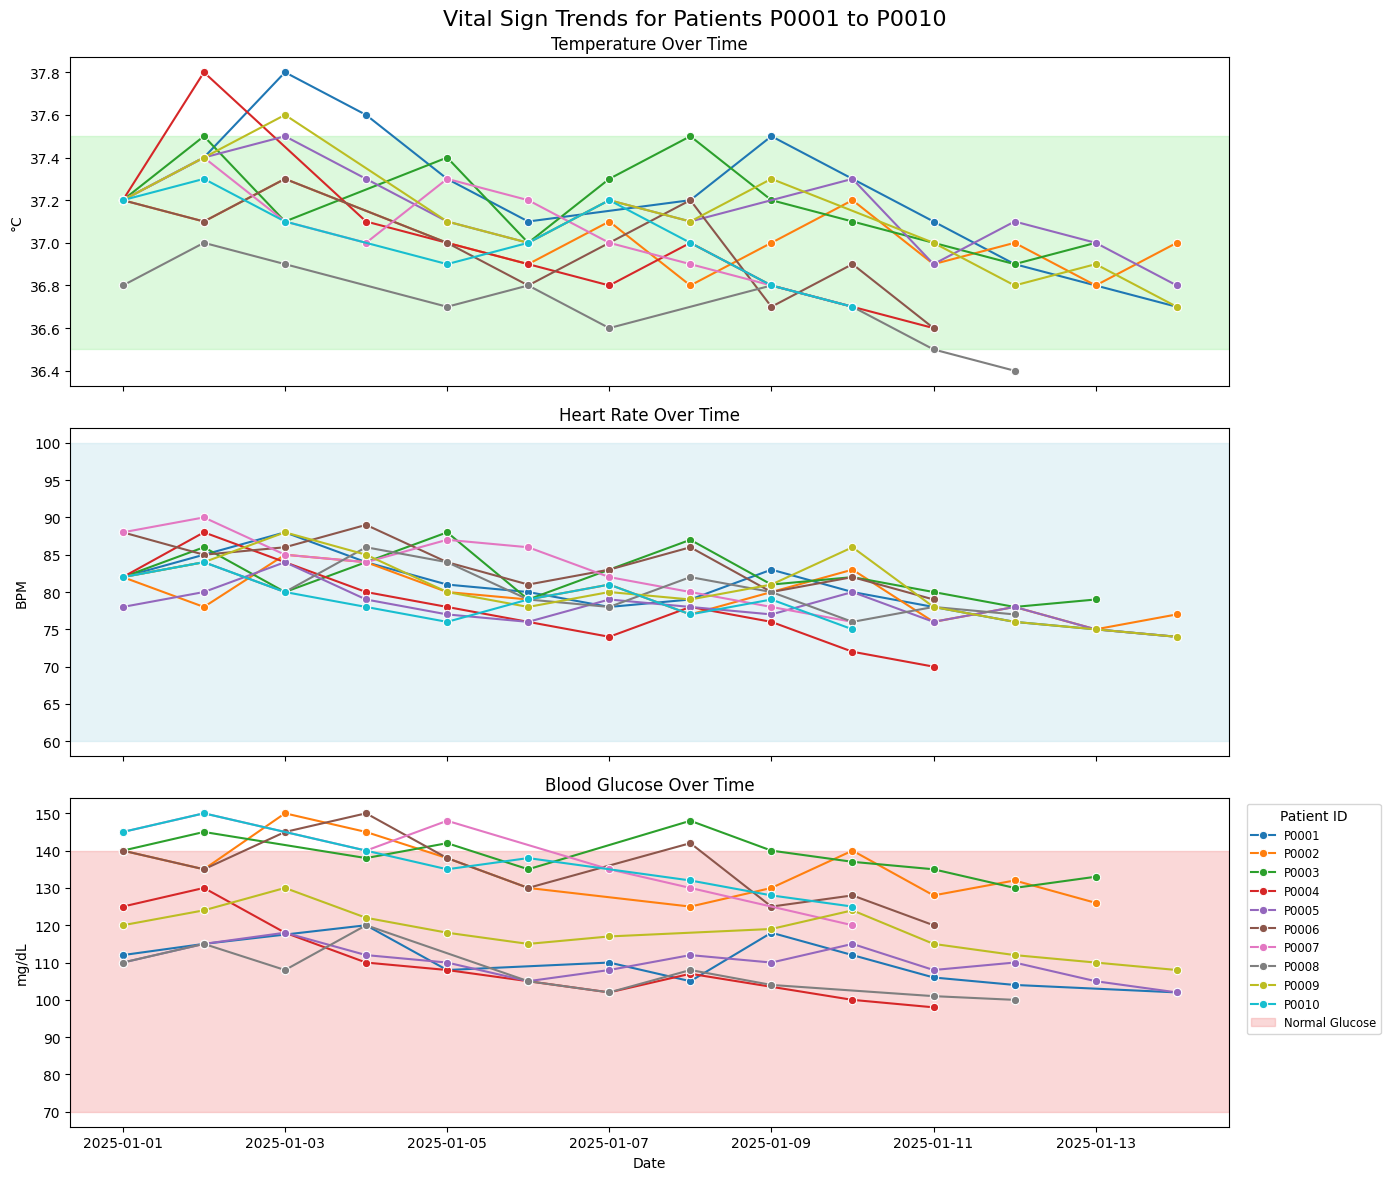

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Define patient range (P0100 to P0120 means index 99 to 120) ===
start_index = 1
end_index = 10

# Get the exact patient IDs (e.g., 'P0100' to 'P0120')
patient_ids = df['patient_id'].unique()
selected_ids = patient_ids[start_index - 1 : end_index]
subset_df = df[df["patient_id"].isin(selected_ids)]

# === Plot time series with clinical reference zones ===
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Temperature
sns.lineplot(ax=axes[0], data=subset_df, x="timestamp", y="temperature", hue="patient_id", marker="o")
axes[0].axhspan(36.5, 37.5, color='lightgreen', alpha=0.3, label='Normal Temp')
axes[0].set_title("Temperature Over Time")
axes[0].set_ylabel("°C")
axes[0].legend().remove()

# Heart Rate
sns.lineplot(ax=axes[1], data=subset_df, x="timestamp", y="heart_rate", hue="patient_id", marker="o")
axes[1].axhspan(60, 100, color='lightblue', alpha=0.3, label='Normal HR')
axes[1].set_title("Heart Rate Over Time")
axes[1].set_ylabel("BPM")
axes[1].legend().remove()

# Blood Glucose
sns.lineplot(ax=axes[2], data=subset_df, x="timestamp", y="blood_glucose", hue="patient_id", marker="o")
axes[2].axhspan(70, 140, color='lightcoral', alpha=0.3, label='Normal Glucose')
axes[2].set_title("Blood Glucose Over Time")
axes[2].set_ylabel("mg/dL")
axes[2].set_xlabel("Date")
axes[2].legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize="small", title="Patient ID")

plt.suptitle(f"Vital Sign Trends for Patients P{start_index:04d} to P{end_index:04d}", fontsize=16)
plt.tight_layout()
plt.show()

**Step 4: Patient Hospitalization Duration Distribution**

This step calculates the number of days each patient remained under daily monitoring by counting the number of records per patient ID. The result is visualized as a histogram to show the distribution of hospitalization durations across all patients. This helps identify how many patients were monitored for short, typical, or full durations (up to 30 days), reflecting real-world discharge or deterioration scenarios.

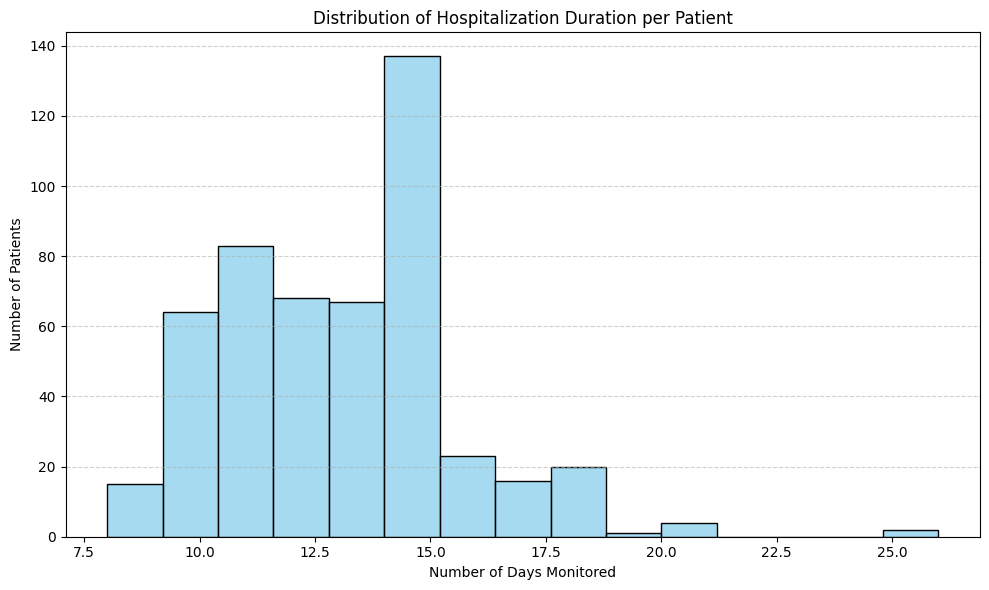

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count hospitalization duration per patient
duration_df = df.groupby("patient_id").size().reset_index(name="days_monitored")

# Plot histogram or barplot
plt.figure(figsize=(10, 6))
sns.histplot(duration_df["days_monitored"], bins=15, kde=False, color="skyblue")
plt.title("Distribution of Hospitalization Duration per Patient")
plt.xlabel("Number of Days Monitored")
plt.ylabel("Number of Patients")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [22]:
# Display the top 10 patients with the longest monitoring durations
duration_df.sort_values("days_monitored", ascending=False).head(10)

,patient_id,days_monitored
281,P0282,26
401,P0402,25
312,P0313,20
89,P0090,20
233,P0234,20
227,P0228,20
81,P0082,19
327,P0328,18
74,P0075,18
97,P0098,18


**Step 5: Clinical Note Summarization using LLMs (e.g., GPT-4o)**

This step leverages Large Language Models (LLMs) to generate concise, high-level summaries of each patient's clinical progression across the monitoring period:

1. Aggregate Clinical Notes
Daily **clinical_note** entries are grouped by patient and concatenated into a single text block, providing a comprehensive view of the patient's condition evolution.

2. Design Structured Summarization Prompt
A structured prompt is crafted to guide the LLM in summarizing key clinical trends, such as recovery, deterioration, or stabilization, while maintaining a professional medical tone.

3. LLM Invocation for Each Patient
The structured prompt is sent to GPT-4o (or an equivalent LLM) on a per-patient basis, ensuring that each summary captures trend patterns, notable events, and the final clinical outcome.

4. Export Summarized Results
The generated summaries are consolidated into a CSV file, enabling further analysis, visualization, or integration into downstream modeling tasks.

In [14]:
# Group and prepare all_notes
patient_notes = df.groupby("patient_id")["clinical_note"].apply(lambda x: "\n".join(x)).reset_index()
patient_notes.columns = ["patient_id", "all_notes"]

# Define system prompt
system_prompt = "You are a senior clinical analyst. Summarize patient trend professionally."

# Generate prompts
def generate_summary_prompt(pid, notes):
    return f"""
Patient ID: {pid}
{notes}
Summarize in 2–3 sentences:
- Overall trend
- Turning points
- Final outcome
"""
summary_prompts = patient_notes.apply(lambda row: generate_summary_prompt(row["patient_id"], row["all_notes"]), axis=1)

In [24]:
from tqdm import tqdm

summaries = []

for idx, prompt in tqdm(summary_prompts.items(), total=len(summary_prompts), desc="Generating Summaries"):
    pid = patient_notes.loc[idx, "patient_id"]
    output = model_prompt(prompt, system_prompt=system_prompt)
    summaries.append({
        "patient_id": pid,
        "summary": output
    })

Generating Summaries: 100%|██████████| 500/500 [45:34<00:00,  5.47s/it]


In [25]:
# Save the summary dataset
summary_df = pd.DataFrame(summaries)
summary_df.to_csv(my_file_path+"patient_summary.csv", index=False)
summary_df.head()

,patient_id,summary
0,P0001,The patient demonstrated a steady recovery pos...
1,P0002,The patient demonstrated a stable and progress...
2,P0003,The patient demonstrated a steady recovery pos...
3,P0004,The patient demonstrated a steady and progress...
4,P0005,The patient demonstrated a stable recovery tra...


# **🧼 3. Advanced Data Preprocessing with SLMs / LLMs**

This section demonstrates the use of advanced preprocessing techniques to prepare a patient monitoring dataset for analysis or modeling. The process includes intelligent missing value handling, feature normalization, categorical feature encoding, application of Small Language Models (SLMs) for text embedding or enhancement

**Step 1: Categorical Feature Encoding**

The composite blood_pressure string (e.g., "120/80") is split into two separate numerical columns: systolic_bp and diastolic_bp. This improves model interpretability and allows for numerical analysis or binning of these values.

In [15]:
df_cleaned = df.copy()
df_cleaned[["systolic_bp", "diastolic_bp"]] = df["blood_pressure"].str.split("/", expand=True).astype(float)
df_cleaned = df_cleaned.drop(columns=["blood_pressure"])

In [16]:
# Preview
df_cleaned.info()
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6501 entries, 0 to 6500
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         6501 non-null   object        
 1   timestamp          6501 non-null   datetime64[ns]
 2   oxygen_saturation  6501 non-null   int64         
 3   heart_rate         6501 non-null   int64         
 4   temperature        5832 non-null   float64       
 5   weight             6110 non-null   float64       
 6   blood_glucose      5653 non-null   float64       
 7   clinical_note      6501 non-null   object        
 8   systolic_bp        6494 non-null   float64       
 9   diastolic_bp       6494 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 508.0+ KB


,patient_id,timestamp,oxygen_saturation,heart_rate,temperature,weight,blood_glucose,clinical_note,systolic_bp,diastolic_bp
0,P0001,2025-01-01,96,82,37.2,70.5,112.0,Patient stable post-surgery. Vitals within nor...,128.0,82.0
1,P0001,2025-01-02,95,85,37.4,70.3,115.0,Mildly elevated heart rate and temperature. Mo...,130.0,84.0
2,P0001,2025-01-03,94,88,37.8,70.2,NaN,Temperature trending upward. Possible low-grad...,132.0,86.0
3,P0001,2025-01-04,95,84,37.6,70.1,120.0,Temperature stabilizing. Patient reports impro...,130.0,85.0
4,P0001,2025-01-05,96,81,37.3,70.1,108.0,Patient showing signs of steady recovery. Vita...,126.0,82.0


**Step 2: Intelligent Per-Patient Missing Value Handling**

To preserve individual variation in clinical patterns, missing values in key physiological metrics — including temperature, weight, blood glucose, and blood pressure (systolic and diastolic) — are imputed separately for each patient using their own median values. This patient-centric approach ensures that imputation aligns with personal baselines and avoids distortion from population-level statistics, maintaining the integrity of temporal health trends for downstream analysis.

In [17]:
fill_cols = ["temperature", "weight", "blood_glucose", "systolic_bp", "diastolic_bp"]
for col in fill_cols:
    df_cleaned[col] = df_cleaned.groupby("patient_id")[col].transform(lambda x: x.fillna(x.median()))

In [18]:
# Preview
df_cleaned.info()
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6501 entries, 0 to 6500
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         6501 non-null   object        
 1   timestamp          6501 non-null   datetime64[ns]
 2   oxygen_saturation  6501 non-null   int64         
 3   heart_rate         6501 non-null   int64         
 4   temperature        6501 non-null   float64       
 5   weight             6501 non-null   float64       
 6   blood_glucose      6501 non-null   float64       
 7   clinical_note      6501 non-null   object        
 8   systolic_bp        6501 non-null   float64       
 9   diastolic_bp       6501 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 508.0+ KB


,patient_id,timestamp,oxygen_saturation,heart_rate,temperature,weight,blood_glucose,clinical_note,systolic_bp,diastolic_bp
0,P0001,2025-01-01,96,82,37.2,70.5,112.0,Patient stable post-surgery. Vitals within nor...,128.0,82.0
1,P0001,2025-01-02,95,85,37.4,70.3,115.0,Mildly elevated heart rate and temperature. Mo...,130.0,84.0
2,P0001,2025-01-03,94,88,37.8,70.2,110.0,Temperature trending upward. Possible low-grad...,132.0,86.0
3,P0001,2025-01-04,95,84,37.6,70.1,120.0,Temperature stabilizing. Patient reports impro...,130.0,85.0
4,P0001,2025-01-05,96,81,37.3,70.1,108.0,Patient showing signs of steady recovery. Vita...,126.0,82.0


**Step 3: Numerical Feature Normalization**

To enable fair comparisons between patients and prevent scale dominance in modeling, key numeric features (e.g., temperature, heart rate, blood glucose) are standardized using z-score normalization. This transformation centers the values around zero and scales them by standard deviation.

In [19]:
from sklearn.preprocessing import StandardScaler

norm_cols = ["temperature", "heart_rate", "blood_glucose"]
scaler = StandardScaler()
df_cleaned[[f"{col}_zscore" for col in norm_cols]] = scaler.fit_transform(df_cleaned[norm_cols])

In [20]:
# Preview
df_cleaned.info()
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6501 entries, 0 to 6500
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   patient_id            6501 non-null   object        
 1   timestamp             6501 non-null   datetime64[ns]
 2   oxygen_saturation     6501 non-null   int64         
 3   heart_rate            6501 non-null   int64         
 4   temperature           6501 non-null   float64       
 5   weight                6501 non-null   float64       
 6   blood_glucose         6501 non-null   float64       
 7   clinical_note         6501 non-null   object        
 8   systolic_bp           6501 non-null   float64       
 9   diastolic_bp          6501 non-null   float64       
 10  temperature_zscore    6501 non-null   float64       
 11  heart_rate_zscore     6501 non-null   float64       
 12  blood_glucose_zscore  6501 non-null   float64       
dtypes: datetime64[ns](

,patient_id,timestamp,oxygen_saturation,heart_rate,temperature,weight,blood_glucose,clinical_note,systolic_bp,diastolic_bp,temperature_zscore,heart_rate_zscore,blood_glucose_zscore
0,P0001,2025-01-01,96,82,37.2,70.5,112.0,Patient stable post-surgery. Vitals within nor...,128.0,82.0,0.360442,0.256585,-0.617148
1,P0001,2025-01-02,95,85,37.4,70.3,115.0,Mildly elevated heart rate and temperature. Mo...,130.0,84.0,1.089682,0.881403,-0.438365
2,P0001,2025-01-03,94,88,37.8,70.2,110.0,Temperature trending upward. Possible low-grad...,132.0,86.0,2.548162,1.506221,-0.736337
3,P0001,2025-01-04,95,84,37.6,70.1,120.0,Temperature stabilizing. Patient reports impro...,130.0,85.0,1.818922,0.673130,-0.140392
4,P0001,2025-01-05,96,81,37.3,70.1,108.0,Patient showing signs of steady recovery. Vita...,126.0,82.0,0.725062,0.048312,-0.855527


**Step 4: LLM-Based Clinical Note Classification using Hugging Face**

To extract semantic meaning from free-text clinical notes, a zero-shot classification model (e.g., facebook/bart-large-mnli) is used. It assigns each note to one of four predefined health statuses:
*   Stable – Patient remained within normal clinical limits.
*   Recovering – Patient shows gradual improvement.
*   Deteriorating – Worsening symptoms or instability detected.
*   Critical – Severe decline or urgent care required.

This enables modeling and visualization of patient recovery trajectories without manual annotation.

In [21]:
import torch
# Device Detection (GPU if available)
device = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if device == 0 else "CPU")

Using device: GPU


In [22]:
from transformers import pipeline

# Load zero-shot classifier
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device
)
# Define medical status labels
labels = ["Stable", "Recovering", "Deteriorating", "Critical"]

# Initialize empty column for note_status
df_cleaned["note_status"] = None

Device set to use cuda:0


In [23]:
from tqdm import tqdm
# Start classification
print("Starting clinical note classification with Hugging Face zero-shot model...\n")

for idx, text in tqdm(enumerate(df_cleaned["clinical_note"]), total=len(df_cleaned), desc="Classifying Notes"):
    result = classifier(text, candidate_labels=labels)
    df_cleaned.loc[idx, "note_status"] = result["labels"][0]  # Choose the most likely label

Starting clinical note classification with Hugging Face zero-shot model...



Classifying Notes: 100%|██████████| 6501/6501 [08:55<00:00, 12.15it/s]


In [24]:
# Save classified results
df_cleaned.to_csv(my_file_path + "preprocessing_generate_patient_dataset.csv", index=False)

# Preview sample
df_cleaned[["patient_id", "timestamp", "clinical_note", "note_status"]].head()

,patient_id,timestamp,clinical_note,note_status
0,P0001,2025-01-01,Patient stable post-surgery. Vitals within nor...,Stable
1,P0001,2025-01-02,Mildly elevated heart rate and temperature. Mo...,Recovering
2,P0001,2025-01-03,Temperature trending upward. Possible low-grad...,Recovering
3,P0001,2025-01-04,Temperature stabilizing. Patient reports impro...,Stable
4,P0001,2025-01-05,Patient showing signs of steady recovery. Vita...,Recovering


In [27]:
# Distribution of classified note_status labels.
df_cleaned["note_status"].value_counts()

,count
note_status,
Stable,3346
Recovering,2775
Deteriorating,224
Critical,156


# **📝 4. AI-Assisted Summary Report and Visualization**